<a href="https://colab.research.google.com/github/berina-spirjan1/olx-used-cars-prediction/blob/main/olx_used_car_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>  **Detalji:** Cilj ovog projekta jeste da napravimo model koji će vršiti predikciju cijena polovnih automobila. Kao dataset na kojem ćemo trenirati naš model, koristiti ćemo bazu podataka poznate web stranice [olx.ba](https://olx.ba/).



In [ ]:
import os
import json
import csv
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed

>  ##### Funkciju save_data koristimo za spremanje podataka u JSON formatu *za* odredjeni fajl.


In [ ]:
def save_data(filename, data):
    with open(f"{filename}.json", 'w') as file:
        json.dump(data, file, indent=4)


>  ##### Funkcija request_data je dizajnirana za slanje HTTP GET requesta za odredjeeni URL sa zadanim headerom i parametrima. Koristimo je za dobavljanje podataka sa olx.ba stranice.

In [ ]:
def request_data(url, headers, params=None):
    response = requests.get(url, headers=headers, params=params)
    return response

>  ##### Funkcija fetch_page je dizajnirana za dohvaćanje podataka sa specificirane stranice API-ja, koristeći zadane parametre i headers. Ako je odgovor success, podaci se vraćaju u JSON formatu.

In [ ]:
def fetch_page(page, quantity, headers, url):
    params = {
        "category_id": 18,
        "per_page": quantity * 100,
        "page": page
    }
    response = request_data(url, headers, params)
    if response.status_code == 200:
        try:
            data = response.json()
            print(f"Page {page} data fetched successfully")
            return data
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on page {page}: {e}")
            return None
    else:
        print(f"Error fetching page {page} data. Status code: {response.status_code}")
        return None

>  ##### Funkcija fetch_all_cars je dizajnirana za paralelno dohvaćanje podataka o automobilima sa API-ja koristeći više threads. Funkcija koristi prethodno definiranu fetch_page funkciju za dohvaćanje podataka sa pojedinačnih stranica i pohranjuje dohvaćene podatke **u** JSON datoteke.

In [ ]:
def fetch_all_cars(quantity=1, max_workers=10):
    headers = {
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
    }
    url = "https://olx.ba/api/search"
    page = 1
    all_data = []
    total_pages = 70

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_page = {executor.submit(fetch_page, page, quantity, headers, url): page for page in range(1, total_pages + 1)}

        for future in as_completed(future_to_page):
            page = future_to_page[future]
            try:
                page_data = future.result()
                if page_data and "data" in page_data:
                    all_data.extend(page_data["data"])
                    save_data(f"data/cars_page_{page}", page_data)
                    print(f"Page {page} data saved")
                else:
                    print(f"No data on page {page}")
            except Exception as e:
                print(f"Error processing page {page}: {e}")

    return all_data


>  ##### Funkcija fetch_listing_details je dizajnirana za dohvaćanje detalja o određenom oglasu koristeći GET request. Funkcija koristi prethodno definiranu request_data funkciju za slanje requesta i obrađuje response u JSON formatu.#

In [ ]:
def fetch_listing_details(listing_id, headers):
    url = f"https://olx.ba/api/listings/{listing_id}"
    response = request_data(url, headers)
    if response.status_code == 200:
        try:
            return response.json()
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON for listing {listing_id}: {e}")
            return None
    else:
        print(f"Error fetching listing {listing_id}. Status code: {response.status_code}")
        return None

##### Funkcija collect_all_fields se koristi za prikupljanje svih jedinstvenih polja iz atributa automobila u JSON datotekama unutar zadane mape. Funkcija koristi fetch_listing_details za dohvaćanje detalja o svakom oglasu i prikuplja sve jedinstvene nazive atributa.

In [ ]:
def collect_all_fields(input_folder, headers):
    all_fields = set()


    for filename in os.listdir(input_folder):
        if filename.startswith("cars_page_") and filename.endswith(".json"):
            with open(os.path.join(input_folder, filename), 'r', encoding='utf-8') as json_file:
                data = json.load(json_file)
                if "data" in data:
                    for car in data["data"]:
                        listing_id = car.get("id")
                        if listing_id:
                            details = fetch_listing_details(listing_id, headers)
                            if details:
                                if 'attributes' in details:
                                    attributes = details['attributes']
                                    for attribute in attributes:
                                        all_fields.add(attribute['name'])

    return all_fields



>   ##### Funkcija convert_all_json_to_csv je implementirana za konvertovanje svih JSON datoteka unutar zadane mape u CSV format. Funkcija koristi fetch_listing_details za dohvaćanje dodatnih detalja o svakom oglasu i prikuplja sve podatke u CSV datoteku.

In [ ]:
def convert_all_json_to_csv(input_folder, output_file, all_fields):
    headers = {
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
    }
    all_data = []


    for filename in os.listdir(input_folder):
        if filename.startswith("cars_page_") and filename.endswith(".json"):
            filepath = os.path.join(input_folder, filename)
            print(f"Processing file: {filepath}")
            with open(filepath, 'r', encoding='utf-8') as json_file:
                data = json.load(json_file)
                if "data" in data:
                    for car in data["data"]:
                        listing_id = car.get("id")
                        if listing_id:
                            details = fetch_listing_details(listing_id, headers)
                            if details:
                                if 'attributes' in details:
                                    attributes = details['attributes']
                                    for attribute in attributes:
                                        details[attribute['name']] = attribute['value']
                                    del details['attributes']
                                all_data.append(details)

    if all_data:
        fieldnames = list(all_fields)
        with open(output_file, 'w', newline='', encoding='utf-8') as csv_file:
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()
            for car in all_data:
                writer.writerow(car)
        print(f"Svi podaci su uspešno sačuvani u {output_file}")
    else:
        print("Nema podataka o vozilima u JSON datotekama.")

##### Ovo omogućava pristup datotekama pohranjenim na Google Drive-u direktno iz Google Colab okruženja.

In [ ]:
from google.colab import drive
import os
import json


drive.mount('/content/drive')

Mounted at /content/drive


>  ##### Ovaj blok koda je namijenjen za učitavanje svih JSON datoteka iz foldera na Google Drive-u unutar Google Colab okruženja. Provjeravamo da li postoji folder, ispisuje listu JSON datoteka unutar foldera, i učitava sadržaj tih fileova u listu.

In [ ]:
json_directory = '/content/drive/MyDrive/data/'

if os.path.exists(json_directory):
    json_files = os.listdir(json_directory)
    print("JSON files in directory:", json_files)
else:
    print(f"Directory {json_directory} does not exist.")

all_data = []
for json_file in json_files:
    if json_file.endswith('.json'):
        with open(os.path.join(json_directory, json_file), 'r', encoding='utf-8') as f:
            data = json.load(f)
            all_data.append(data)


JSON files in directory: ['cars_page_61.json', 'cars_page_1.json', 'cars_page_2.json', 'cars_page_3.json', 'cars_page_4.json', 'cars_page_5.json', 'cars_page_6.json', 'cars_page_8.json', 'cars_page_7.json', 'cars_page_9.json', 'cars_page_10.json', 'cars_page_11.json', 'cars_page_12.json', 'cars_page_13.json', 'cars_page_15.json', 'cars_page_14.json', 'cars_page_16.json', 'cars_page_17.json', 'cars_page_18.json', 'cars_page_19.json', 'cars_page_20.json', 'cars_page_21.json', 'cars_page_22.json', 'cars_page_23.json', 'cars_page_24.json', 'cars_page_25.json', 'cars_page_26.json', 'cars_page_27.json', 'cars_page_28.json', 'cars_page_29.json', 'cars_page_31.json', 'cars_page_30.json', 'cars_page_32.json', 'cars_page_33.json', 'cars_page_34.json', 'cars_page_35.json', 'cars_page_36.json', 'cars_page_37.json', 'cars_page_38.json', 'cars_page_40.json', 'cars_page_39.json', 'cars_page_41.json', 'cars_page_42.json', 'cars_page_43.json', 'cars_page_44.json', 'cars_page_46.json', 'cars_page_45.jso

>  ##### Ovaj kod učitava sve JSON datoteke iz specificiranog direktorija na Google Drive-u unutar Google Colab okruženja, ispisuje broj učitanih datoteka i njihov sadržaj u strukturiranom formatu. Ovo koristimo samo za testiranje da bismo se uvjerili da su fajlovi ispravno ucitani.

In [ ]:
print(f"Loaded {len(all_data)} JSON files.")
for data in all_data:
    print(json.dumps(data, indent=2))


Streaming output truncated to the last 5000 lines.
      "user_id": 48818,
      "state": "used",
      "status": "active",
      "location": null,
      "labels": [
        "Dizel",
        298563
      ],
      "listing_type": "sell",
      "special_labels": [
        {
          "value": "dizel",
          "label": "Gorivo",
          "unit": null
        },
        {
          "value": "298.563",
          "label": "Kilometra\u017ea",
          "unit": "km"
        },
        {
          "value": 2009,
          "label": "Godi\u0161te",
          "unit": null
        }
      ]
    },
    {
      "score": null,
      "id": 61451964,
      "type": "single",
      "title": "Renault Kangoo 1.5 DCI..DIZEL..FAMILY...2012 GOD...UVOZ CH..",
      "category_id": 18,
      "top_category_id": "1",
      "brand_id": 71,
      "city_id": 75,
      "has_discount": false,
      "discounted_price_float": 12850,
      "discounted_price": "12.850 KM",
      "show_price": true,
      "price": 12850,


>  ###### Definisemo putanju do foldera iz kojeg cemo dobaviti JSON datoteke. Te definisemo headers, kako bismo izbjegli mogucnost dobijanja 403, odnosno status codea forbidden. Sprecavamo mogucnost pojavljivanja CORS errora.

In [ ]:
# Prvo prikupi sva jedinstvena polja iz svih JSON fajlova
input_folder = "/content/drive/MyDrive/data/"
headers = {
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
}

>  ##### Pozivamo funkciju da dobavimo sve automobile sa olx.ba stranice i spasavamo ih u niz all_data.

In [ ]:
print("Fetching all car data...")
all_data = fetch_all_cars(quantity=1)
print("Fetching complete")


Fetching all car data...
Page 4 data fetched successfully
Error processing page 4: [Errno 2] No such file or directory: 'data/cars_page_4.json'
Page 5 data fetched successfully
Error processing page 5: [Errno 2] No such file or directory: 'data/cars_page_5.json'
Page 10 data fetched successfully
Page 3 data fetched successfully
Error processing page 10: [Errno 2] No such file or directory: 'data/cars_page_10.json'
Error processing page 3: [Errno 2] No such file or directory: 'data/cars_page_3.json'
Page 2 data fetched successfully
Page 1 data fetched successfullyError processing page 2: [Errno 2] No such file or directory: 'data/cars_page_2.json'Page 9 data fetched successfully

Page 6 data fetched successfully

Error processing page 9: [Errno 2] No such file or directory: 'data/cars_page_9.json'
Error processing page 1: [Errno 2] No such file or directory: 'data/cars_page_1.json'
Error processing page 6: [Errno 2] No such file or directory: 'data/cars_page_6.json'
Page 7 data fetched 

>  ###### Prikupljamo sva unikatna polja iz JSON fajlova kako bismo na osnovu njih mogli kreirati u konacnici CSV datoteku na osnovu koje cemo vrsiti procesuiranje podataka.

In [ ]:
print("Collecting all fields...")
all_fields = collect_all_fields(input_folder, headers)
print("Fields collected")

>  ##### Pretvaramo sve JSON fajlove u jedan CVS fajl koji cemo koristiti za preprocesuiranje




In [ ]:
# Pretvaramo sve JSON fajlove u jedan CVS fajl koji cemo koristiti za preprocesuiranje

print("Converting JSON to CSV...")
convert_all_json_to_csv(input_folder, "cars.csv", all_fields)
print("Conversion complete")

>  # ***Preprocesuiranje podataka***



> #### Ova sekcija pokriva postupak učitavanja, preprocesuiranja i transformacije podataka automobila pohranjenih u CSV datoteku. Koraci uključuju učitavanje podataka, provjeru podataka, čišćenje podataka, transformaciju podataka i spremanje podataka.

Obrazlozenje vezano za podatke koji ce biti uklonjeni ili popunjeni odgovarajucim vrijednostima u sljedecem segmentu koda. Inace ovi argumenti ne utjecu na cijenu prilikom prodaje/kupovine/potraznje automobila:


1. **created_at** datum kreiranja oglasa nije relevantan za analizu trenutne vrijednosti i karakteristika automobila
2. **image_masking** informacija o maskiranju slika ne doprinosi razumijevanju karakteristika ili cijene automobila
3. **id** id nema analitičku vrijednost u kontekstu karakteristika i cijene automobila
4. **date** datum oglasa može biti koristan za vremensku analizu, ali nije direktno relevantan za trenutnu analizu karakteristika i cijene automobila
5. **questions** broj pitanja postavljenih na oglasu ne daje korisne informacije o samim karakteristikama automobila.
6. **attributes** ova kolona je izostavljena jer se detalji atributa izvlače i prebacuju u zasebne kolone za analizu
7. **images** informacija o slikama automobila nije relevantna za analizu karakteristika i cijene
8. **status** status oglasa (aktivan, istekao, itd.) nije relevantan za analizu karakteristika i cijene automobila
9. **available** informacija o dostupnosti oglasa nije relevantna za analizu karakteristika i cijene automobila
10. **images_old** stare slike automobila nisu relevantne za trenutnu analizu
11. **short_description** kratki opis oglasa može biti subjektivan i nije standardiziran za analizu
12. **highlighted** informacija o istaknutosti oglasa nije relevantna za analizu karakteristika i cijene automobila
13. **has_discount** informacija o popustima nije standardizirana i može biti vremenski ograničena
14. **title** naslov oglasa može biti subjektivan i ne pruža standardizirane informacije o karakteristikama automobila
15. **sponsored** informacija o sponzoriranju oglasa nije relevantna za analizu karakteristika i cijene automobila
16. **visible** informacija o vidljivosti oglasa nije relevantna za analizu karakteristika i cijene automobila
17. **feedbacks** povratne informacije korisnika mogu biti subjektivne i nisu standardizirane za analizu
18. **price_history** historija cijena može biti korisna za vremensku analizu, ali nije relevantna za trenutnu analizu karakteristika automobila
19. **category_id** svi automobili imaju kategoriju 18, jer su na osnovu tog id-ija dobavljane s olx stranice
20. **additional** dodatne informacije nisu standardizirane i mogu biti subjektivne
21. **image_masking_status** informacija o statusu maskiranja slika nije relevantna za analizu karakteristika i cijene automobila
22. **regular_price** informacije o regularnoj cijeni koje su koristene u ovom polju su iste kao i one cijene koje su unesene u polju price, na koje cemo uzeti kao polje na osnovu kojeg radimo predikciju
23. **listing_type** tip oglasa nije relevantan za analizu karakteristika i cijene automobila
24. **type** tip oglasa nije relevantan za analizu karakteristika i cijene automobila
25. **show_price** informacija o prikazivanju cijene nije relevantna za analizu karakteristika i cijene automobila
26. **Masa/Težina (kg)** težina automobila može biti korisna, ali nije uvijek dostupna i standardizirana, a i inace ne utjece na cijenu prilikom kupovine
27. **shipping** informacija o dostavi nije relevantna za analizu karakteristika i cijene automobila
28. **state** stanje automobila je već filtrirano da se uzimaju u obzir samo 'used' automobili
29. **Veličina felgi** informacija o veličini felgi može biti korisna, ali nije uvijek dostupna i standardizirana
31. **exchange_for** informacija o razmjeni automobila nije relevantna za analizu karakteristika i cijene automobila
32. **urgent** informacija o hitnosti oglasa nije relevantna za analizu karakteristika i cijene automobila.
33. **price_by_agreement** informacija o cijeni po dogovoru nije standardizirana za analizu


In [ ]:
!pip install datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 7.6 MB/s eta 0:00:00


CSV file loaded successfully.
Number of columns in the DataFrame: 116
Column names: Index(['DPF/FAP filter', 'created_at', 'Kubikaža', 'Digitalna klima',
       'image_masking', 'Alarm', 'Vrsta enterijera', 'price_by_agreement',
       'image_masking_status', 'feedbacks',
       ...
       'Ocarinjen', 'title', 'sponsored', 'model', 'Gorivo',
       'Daljinsko otključavanje', 'Električni retrovizori', 'Godište',
       'visible', 'Broj vrata'],
      dtype='object', length=116)
  DPF/FAP filter  created_at  Kubikaža Digitalna klima  image_masking Alarm  \
0           True  1710528399       3.0            True          False  True   
1           True  1717001071       1.9            True          False   NaN   
2            NaN  1717422570       3.0             NaN          False   NaN   
3           True  1717506942       2.0            True          False  True   
4           True  1717595057       1.9             NaN          False   NaN   

   Vrsta enterijera  price_by_agreement im

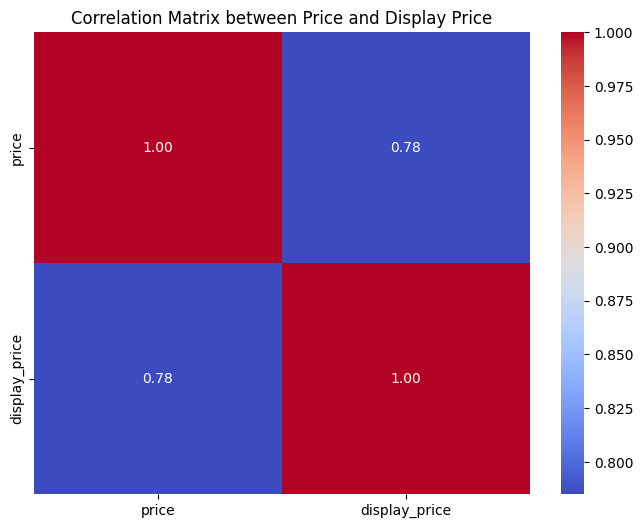

Number of False values in 'shipping_available': 5373
Percentage of False values in 'shipping_available': 100.00%
Dropped 'shipping_available' column because more than 50% values were False
Removed columns due to missing values: ['location', 'urgent', 'Godina prve registracije', 'Na lizingu', 'exchange_for', 'Masa/Težina (kg)', 'sku_number']
Preprocessed data saved to /content/preprocessed_cars.csv


In [24]:
import pandas as pd
import csv
from datetime import datetime
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# ucitavamo dataset koji smo prethodno pohranili u datom folderu
file_path = '/content/cars.csv'

# potrebno je da ucitani csv fajl pretvorimo u dataframe, ali uz to moramo voditi racuna da postoji mogucnost da je doslo do odredjenih problema
#prilikom ucitavanja fajla
try:
    df = pd.read_csv(file_path, quoting=csv.QUOTE_ALL, skipinitialspace=True, on_bad_lines='skip')
    print("CSV file loaded successfully.")
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

# provjeravamo broj kolona koje imamo u nasem dataframeu
print("Number of columns in the DataFrame:", len(df.columns))
print("Column names:", df.columns)


print(df.head())

# Provjera informacija o dataframeu prije transformacija
print(df.info())

# Provjeravamo da li postoji state kolona
if 'state' in df.columns:

    # Provjeravamo da li postoji vrijednost 'used' unutar nase state kolone, jer to nam je signal da je rijec o polovnim
    # automobilima, jer u ovom projektu cemo razmatrati samo polovne automobile
    # ovo ce nam dosta ubrzati proces obrade podataka u nastavku, jer cemo smanjiti nas dataset za treniranje i testiranje
    # samim tim relevantno je samo da koristimo podatke o polovnim automobilima, jer cijene novih ce izazvati odredjena odstupanja
    # u predvidjanju ukoliko ih uzmemo u obzir
    if 'used' in df['state'].values:
        df = df[df['state'] == 'used']
        print(f"Number of rows after filtering 'used' state: {len(df)}")
    else:
        print("'used' value is not present in the 'state' column. No rows to process.")
        # Kreiramo prazan dataframe u slucaju da nemamo polovnih automobila, pretpostavljamo da je u tom slucaju
        # doslo do neke potencijalne greske
        df = pd.DataFrame()
else:
    print("'state' column does not exist in the DataFrame.")

# Ukoliko postoje redovi koje cemo iskoristiti za preprocesuiranje, zapocinjemo preprocesurianje podataka
if not df.empty:
    # Filtriranje redova gdje je cijena "Na upit"
    df = df[~df['price'].astype(str).str.contains("Na upit", na=False)]
    df = df[~df['display_price'].astype(str).str.contains("Na upit", na=False)]

    # Pretvaranje display_price u numerički tip i uklanjanje "KM"
    df['display_price'] = df['display_price'].str.replace('KM', '').str.replace(',', '').astype(float)

    # Zamjena NaN vrijednosti sa srednjom cijenom svih automobila
    median_price = df['price'].median()
    median_display_price = df['display_price'].median()

    df['price'].fillna(median_price, inplace=True)
    df['display_price'].fillna(median_display_price, inplace=True)

    # Izračunavanje korelacije
    correlation_matrix = df[['price', 'display_price']].corr()

    # Prikazivanje matrice korelacije pomoću heatmap-a
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix between Price and Display Price')
    plt.show()


    def extract_brand_name(brand):
        if pd.isna(brand):
            return np.nan
        try:
            if isinstance(brand, str):
                brand_dict = ast.literal_eval(brand)
            elif isinstance(brand, dict):
                brand_dict = brand
            else:
                return brand
            if isinstance(brand_dict, dict) and 'name' in brand_dict:
                return brand_dict['name']
        except (ValueError, SyntaxError):
            pass
        return brand

    # Buduci da se vrijednost u poljima koja pripadaju koloni brand nalaze u obliku objekta,
    # za nasa razmatranja bit ce nam dovoljno da uzmemo u obzir naziv branda, automobila,
    # pa s tim cemo odbaciti propertije id i slug
    if 'brand' in df.columns:
        df['brand'] = df['brand'].apply(extract_brand_name)

    df.drop(columns=['created_at', 'image_masking', 'id', 'date', 'questions', 'attributes',
                     'images', 'status', 'available', 'images_old', 'short_description',
                     'highlighted', 'has_discount', 'sponsored', 'visible', 'feedbacks', 'price_history', 'category_id',
                     'additional', 'image_masking_status', 'regular_price', 'listing_type', 'type',
                     'show_price', 'title', 'Veličina felgi'], inplace=True, errors='ignore')

    # Popunjavamo defaultne vrijednosti za polja koja nisu popunjena,
    # objasnjenja i obrazlozenja zbog cega ih postavljamo na ove vrijednosti ce se naci u segmentu iznad ovog 'code' dijela
    columns_with_defaults = {
        'Kubikaža': df['Kubikaža'].median(),
        'Digitalna klima': False,
        'DPF/FAP filter': False,
        'Alarm': False,
        'Memorija sjedišta': False,
        'Klimatizacija': df['Klimatizacija'].mode()[0] if 'Klimatizacija' in df.columns else None,
        'Bluetooth': False,
        'Emisioni standard': df['Emisioni standard'].mode()[0] if 'Emisioni standard' in df.columns else None,
        'Senzor kiše': False,
        'Servisna knjiga': False,
        'Svjetla': df['Svjetla'].mode()[0] if 'Svjetla' in df.columns else None,
        'Pogon': df['Pogon'].mode()[0] if 'Pogon' in df.columns else None,
        'El. podizači stakala': False,
        'Masaža sjedišta': False,
        'ABS': False,
        'Sjedećih mjesta': df['Sjedećih mjesta'].mode()[0] if 'Sjedećih mjesta' in df.columns else None,
        'Boja': df['Boja'].mode()[0] if 'Boja' in df.columns else None,
        'Registrovan': False,
        'Servo volan': False,
        'El. pomjeranje sjedišta': False,
        'Tip': df['Tip'].mode()[0] if 'Tip' in df.columns else None,
        'Touch screen (ekran)': False,
        'Turbo': False,
        'Senzor auto. svjetla': False,
        'USB port': False,
        'Centralna brava': False,
        'ESP': False,
        'Maglenke': False,
        'Park assist': False,
        'Komande na volanu': False,
        'Metalik': False,
        'Naslon za ruku': False,
        'Start-Stop sistem': False,
        'Prilagođen invalidima': False,
        'Strane tablice': False,
        'Šiber': False,
        'Snaga motora (KW)': df['Snaga motora (KW)'].median() if 'Snaga motora (KW)' in df.columns else None,
        'Broj prethodnih vlasnika': df['Broj prethodnih vlasnika'].mode()[0] if 'Broj prethodnih vlasnika' in df.columns else None,
        'Navigacija': False,
        'Udaren': False,
        'Auto kuka': False,
        'Head up display': False,
        'Zaštita/Blokada': 'ostalo',
        'Garancija': 0,
        'Hill assist': False,
        'Transmisija': df['Transmisija'].mode()[0] if 'Transmisija' in df.columns else None,
        'Car play': False,
        'Broj stepeni prijenosa': df['Broj stepeni prijenosa'].mode()[0] if 'Broj stepeni prijenosa' in df.columns else None,
        'Airbag': False,
        'Panorama krov': False,
        'Grijanje sjedišta': False,
        'Tempomat': False,
        'Senzor mrtvog ugla': False,
        'Alu felge': False,
        'Rolo zavjese': False,
        'Gorivo': df['Gorivo'].mode()[0] if 'Gorivo' in df.columns else None,
        'Tip': df['Tip'].mode()[0] if 'Tip' in df.columns else None,
        'Daljinsko otključavanje': False,
        'Električni retrovizori': False,
        'Godište': df['Godište'].median() if 'Godište' in df.columns else None,
        'Konjskih snaga': df['Konjskih snaga'].median() if 'Konjskih snaga' in df.columns else None,
        'Broj vrata': df['Broj vrata'].mode()[0] if 'Broj vrata' in df.columns else None,
        'Vrsta enterijera': df['Vrsta enterijera'].mode()[0] if 'Vrsta enterijera' in df.columns else None,
        'Lokacija': None,
        'Urgent': None,
        'Posjeduje gume': 'Ostalo',
        'Vrsta enterijera': 'Ostalo',
        'ISOFIX': False,
        'Ocarinjen': False,
        'Oldtimer': False,
        'Muzika/ozvučenje': 'Ostalo',
        'Hlađenje sjedišta': False,
        'Registrovan do': datetime.now().strftime('%m/%Y'),
        'Parking senzori': 'Nema',
        'Vrsta enterijera': 'Ostalo',
        'Klimatizacija': 'Jednozonska',
        'Oldtimer': False,
        'Pogon': 'Prednji',
        'Zaštita/Blokada': 'Ostalo',
        'Garancija': 0,
        'Parking kamera': 'Nema',
        'Posjeduje gume': 'Ostalo',
        'Kilometraža': 0

    }

    # prolazimo kroz kolone i popunjavamo one koje su NaN sa vrijednostima koje smo naveli da su defaultne
    for column, default_value in columns_with_defaults.items():
        if column in df.columns:
            df[column].fillna(default_value, inplace=True)

    # Buduci da velicina felge ne utice na cijenu automobila tokom njegove prodaje, moze jedino utjecati na cijenu
    # kupovine guma s toga cemo i ovu kolonu odbaciti
    if 'Velicina felgi' in df.columns:
        df.drop(columns=['Velicina felgi'], inplace=True)
        print("Dropped 'Velicina felgi' column because it's not necessary for prediction of car price")

    # Uklanjamo 'shipping_available' ukoliko je vecina vrijednosti False,
    # jer nam ni ovaj segment ne utice na cijenu automobila
    if 'shipping_available' in df.columns:
        false_count = (df['shipping_available'] == False).sum()
        total_count = len(df)
        false_percentage = false_count / total_count
        print(f"Number of False values in 'shipping_available': {false_count}")
        print(f"Percentage of False values in 'shipping_available': {false_percentage * 100:.2f}%")

        if false_percentage > 0.5:
            df.drop(columns=['shipping_available'], inplace=True)
            print("Dropped 'shipping_available' column because more than 50% values were False")

    # Izdvajamo kolone koje sadrze boolean vrijednosti
    boolean_columns = ['Digitalna klima', 'DPF/FAP filter', 'Alarm',
                       'Memorija sjedišta', 'Bluetooth', 'Senzor kiše', 'Servisna knjiga',
                       'El. podizači stakala', 'Masaža sjedišta', 'ABS', 'Registrovan', 'Servo volan', 'El. pomjeranje sjedišta', 'Touch screen (ekran)',
                       'Turbo', 'Senzor auto. svjetla', 'USB port', 'Centralna brava', 'ESP', 'Maglenke', 'Park assist', 'Komande na volanu', 'Metalik',
                       'Naslon za ruku', 'Start-Stop sistem', 'Prilagođen invalidima', 'Strane tablice', 'Šiber', 'Navigacija', 'Udaren',
                       'Auto kuka', 'Head up display', 'Hill assist', 'Car play', 'Airbag', 'Panorama krov', 'Grijanje sjedišta', 'Tempomat',
                       'Senzor mrtvog ugla', 'Alu felge', 'Rolo zavjese', 'Daljinsko otključavanje', 'Električni retrovizori','display_price']

    for column in boolean_columns:
        if column in df.columns:
            df[column] = df[column].astype(bool)

    # Funkcija koju koristimo za provjeru i brisanje kolona ukoliko je pojavljivanje polja praznih vrijednosti vece od 50%
    # ovo tek radimo u ovom koraku, jer smo prethodno obradili sve vrijednosti koje uticu na cijenu automobila
    def remove_columns_with_missing_values(df, threshold=0.5):
        missing_percentage = df.isnull().mean()
        columns_to_remove = missing_percentage[missing_percentage > threshold].index.tolist()
        return df.drop(columns=columns_to_remove), columns_to_remove

    # pozivamo funkciju da uklonimo sve nepotrebne kolone koje su ostale
    df, removed_columns = remove_columns_with_missing_values(df, threshold=0.5)

    # Ispisujemo da vidimo koje su to bile kolone, zbog provjere
    print(f"Removed columns due to missing values: {removed_columns}")

    # Vrsimo type cast za kolonu godiste
    if 'Godište' in df.columns:
        df['Godište'] = df['Godište'].astype(int)

    # Exportujemo preprocesuirani dataframe u csv obliku u folder content
    output_file_path = '/content/preprocessed_cars.csv'
    df.to_csv(output_file_path, index=False)
    print(f"Preprocessed data saved to {output_file_path}")



In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ucitavamo preprocesuirani dataset automobila koje smo dobili
file_path = '/content/preprocessed_cars.csv'
df = pd.read_csv(file_path, on_bad_lines='skip', low_memory=False)

# prikazujemo radi testiranja informacije o dataframeu
print(df.info())

# jos jednom se osiguravamo da nemamo podataka sa NaN vrijednostima, te ih izbacujemo
# no u ovom koraku ova linija se i moze izostaviti, jer se takvi podaci sigurno nece pojaviti
df = df.dropna()

# provjera da nema više NaN vrijednosti
print(df.isnull().sum())
# identifikacija numeričkih kolona
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeričke kolone:", numeric_columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5373 entries, 0 to 5372
Data columns (total 83 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DPF/FAP filter            5373 non-null   bool   
 1   Kubikaža                  5373 non-null   float64
 2   Digitalna klima           5373 non-null   bool   
 3   Alarm                     5373 non-null   bool   
 4   Vrsta enterijera          5373 non-null   object 
 5   price_by_agreement        5373 non-null   bool   
 6   views                     5373 non-null   int64  
 7   Memorija sjedišta         5373 non-null   bool   
 8   Klimatizacija             5373 non-null   object 
 9   Bluetooth                 5373 non-null   bool   
 10  Emisioni standard         5373 non-null   object 
 11  Veličina felgi            4032 non-null   object 
 12  Senzor kiše               5373 non-null   bool   
 13  Servisna knjiga           5373 non-null   bool   
 14  Svjetla 

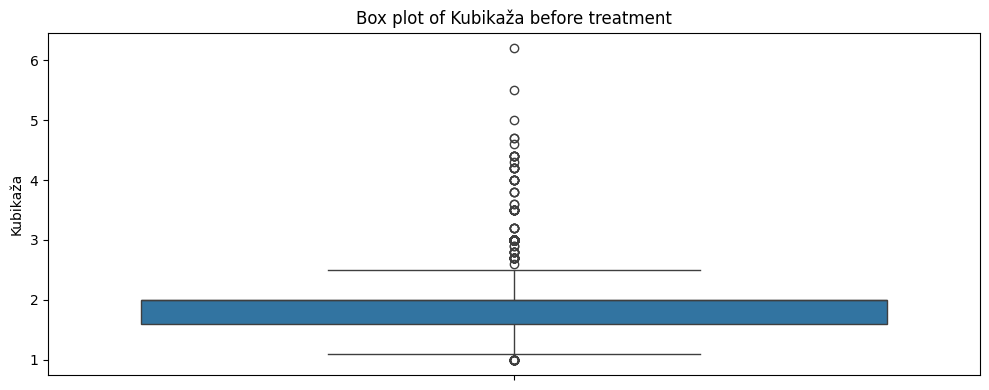

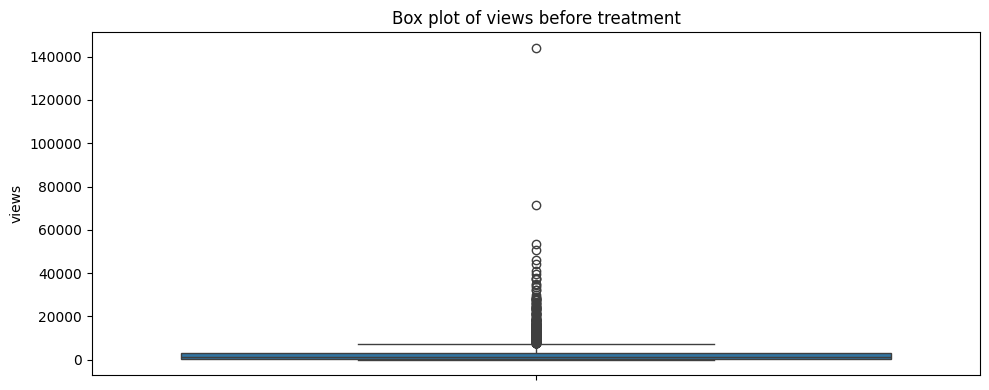

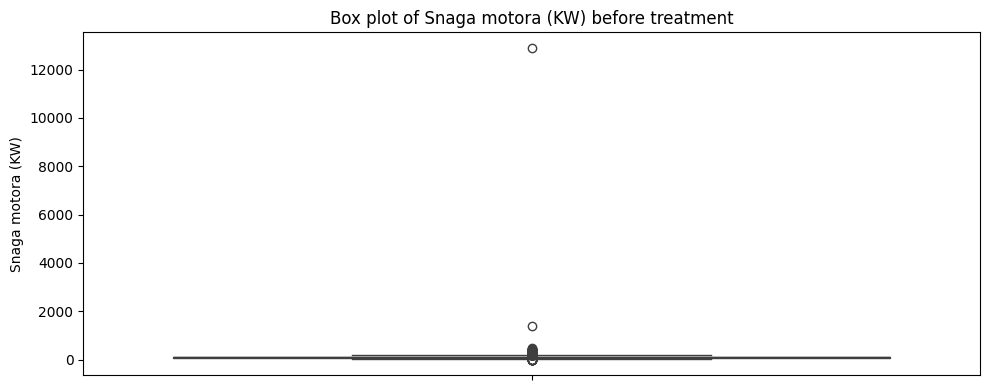

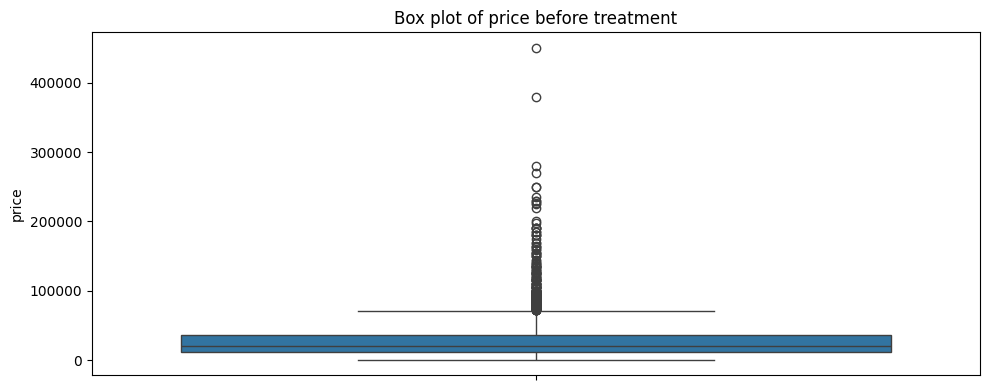

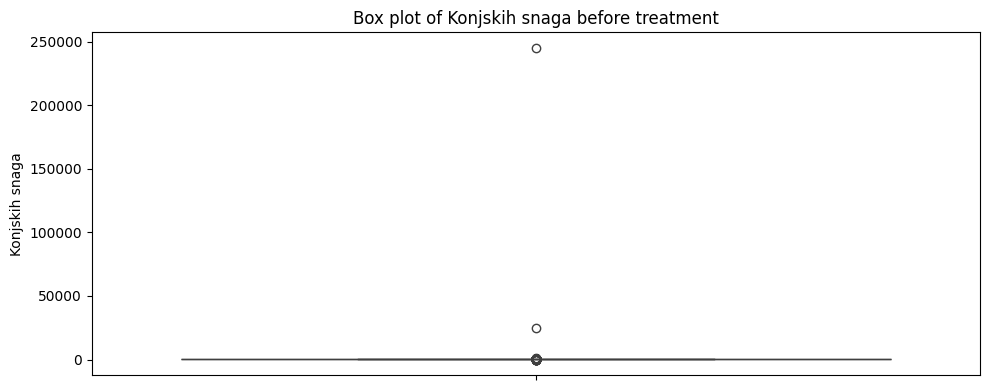

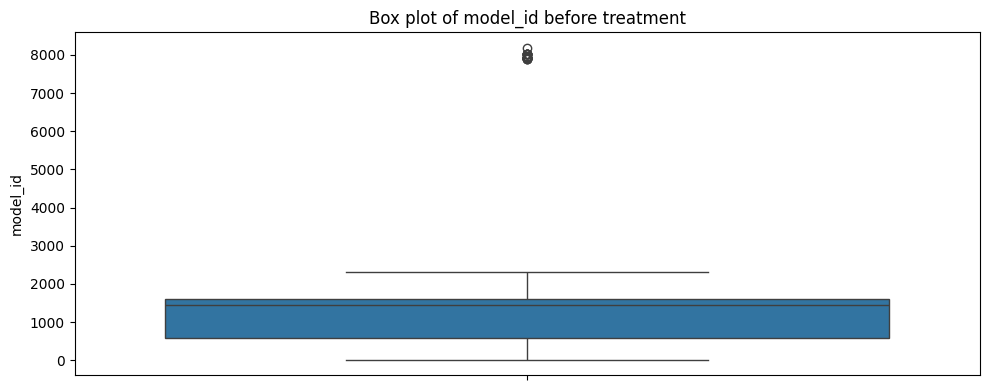

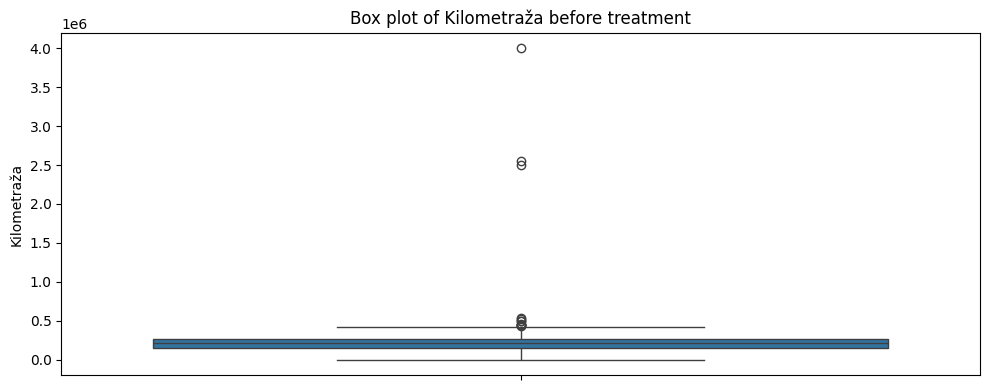

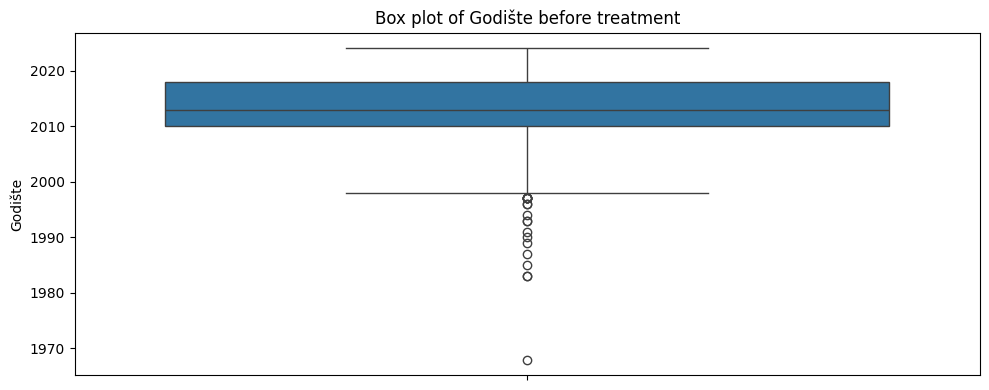

In [6]:
# Vizualizacija box plotova za numeričke kolone prije tretiranja outlayera
for column in numeric_columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(y=df[column])
    plt.title(f'Box plot of {column} before treatment')
    plt.tight_layout()
    plt.show()


In [23]:
# Funkcija za tretiranje outlayera zamjenom s medianom ili mode
def treat_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    default_value = columns_with_defaults.get(column, None)

    if default_value is not None:
        df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = default_value

# Definicija default vrijednosti
columns_with_defaults = {
        'Kubikaža': df['Kubikaža'].median(),
        'Digitalna klima': False,
        'DPF/FAP filter': False,
        'Alarm': False,
        'Memorija sjedišta': False,
        'Klimatizacija': df['Klimatizacija'].mode()[0] if 'Klimatizacija' in df.columns else None,
        'Bluetooth': False,
        'Emisioni standard': df['Emisioni standard'].mode()[0] if 'Emisioni standard' in df.columns else None,
        'Senzor kiše': False,
        'Servisna knjiga': False,
        'Svjetla': df['Svjetla'].mode()[0] if 'Svjetla' in df.columns else None,
        'Pogon': df['Pogon'].mode()[0] if 'Pogon' in df.columns else None,
        'El. podizači stakala': False,
        'Masaža sjedišta': False,
        'ABS': False,
        'Sjedećih mjesta': df['Sjedećih mjesta'].mode()[0] if 'Sjedećih mjesta' in df.columns else None,
        'Boja': df['Boja'].mode()[0] if 'Boja' in df.columns else None,
        'Registrovan': False,
        'Servo volan': False,
        'El. pomjeranje sjedišta': False,
        'Tip': df['Tip'].mode()[0] if 'Tip' in df.columns else None,
        'Touch screen (ekran)': False,
        'Turbo': False,
        'Senzor auto. svjetla': False,
        'USB port': False,
        'Centralna brava': False,
        'ESP': False,
        'Maglenke': False,
        'Park assist': False,
        'Komande na volanu': False,
        'Metalik': False,
        'Naslon za ruku': False,
        'Start-Stop sistem': False,
        'Prilagođen invalidima': False,
        'Strane tablice': False,
        'Šiber': False,
        'Snaga motora (KW)': df['Snaga motora (KW)'].median() if 'Snaga motora (KW)' in df.columns else None,
        'Broj prethodnih vlasnika': df['Broj prethodnih vlasnika'].mode()[0] if 'Broj prethodnih vlasnika' in df.columns else None,
        'Navigacija': False,
        'Udaren': False,
        'Auto kuka': False,
        'Head up display': False,
        'Zaštita/Blokada': 'ostalo',
        'Garancija': 0,
        'Hill assist': False,
        'Transmisija': df['Transmisija'].mode()[0] if 'Transmisija' in df.columns else None,
        'Car play': False,
        'Broj stepeni prijenosa': df['Broj stepeni prijenosa'].mode()[0] if 'Broj stepeni prijenosa' in df.columns else None,
        'Airbag': False,
        'Panorama krov': False,
        'Grijanje sjedišta': False,
        'Tempomat': False,
        'Senzor mrtvog ugla': False,
        'Alu felge': False,
        'Rolo zavjese': False,
        'Gorivo': df['Gorivo'].mode()[0] if 'Gorivo' in df.columns else None,
        'Tip': df['Tip'].mode()[0] if 'Tip' in df.columns else None,
        'Daljinsko otključavanje': False,
        'Električni retrovizori': False,
        'Godište': df['Godište'].median() if 'Godište' in df.columns else None,
        'Konjskih snaga': df['Konjskih snaga'].median() if 'Konjskih snaga' in df.columns else None,
        'Broj vrata': df['Broj vrata'].mode()[0] if 'Broj vrata' in df.columns else None,
        'Vrsta enterijera': df['Vrsta enterijera'].mode()[0] if 'Vrsta enterijera' in df.columns else None,
        'Lokacija': None,
        'Urgent': None,
        'Posjeduje gume': 'Ostalo',
        'Vrsta enterijera': 'Ostalo',
        'ISOFIX': False,
        'Ocarinjen': False,
        'Oldtimer': False,
        'Muzika/ozvučenje': 'Ostalo',
        'Hlađenje sjedišta': False,
        'Registrovan do': datetime.now().strftime('%m/%Y'),
        'Parking senzori': 'Nema',
        'Vrsta enterijera': 'Ostalo',
        'Klimatizacija': 'Jednozonska',
        'Oldtimer': False,
        'Pogon': 'Prednji',
        'Zaštita/Blokada': 'Ostalo',
        'Garancija': 0,
        'Parking kamera': 'Nema',
        'Posjeduje gume': 'Ostalo',
        'Kilometraža': 0
}

# Tretiranje outlayera za numeričke kolone
for column in numeric_columns:
    treat_outliers(column)


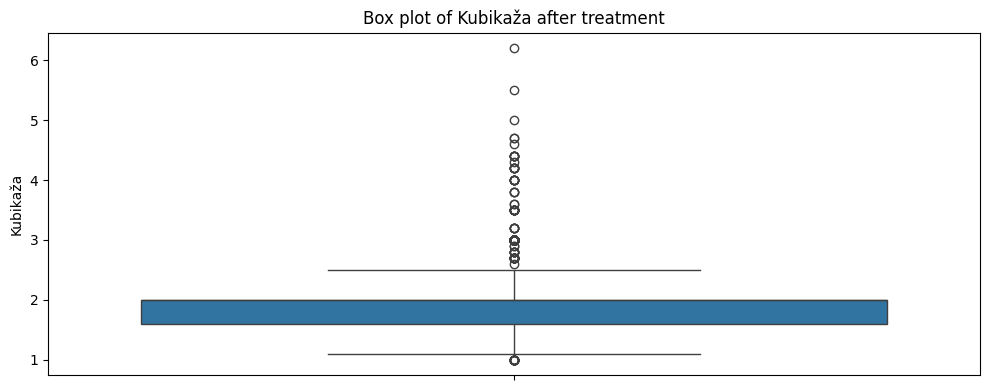

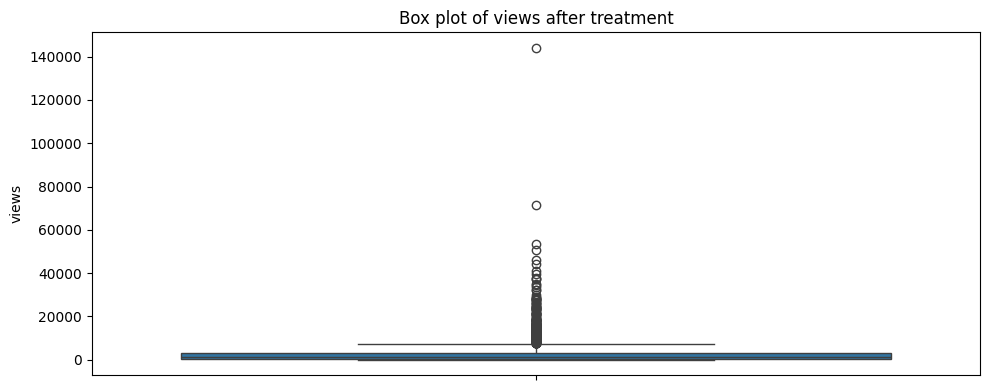

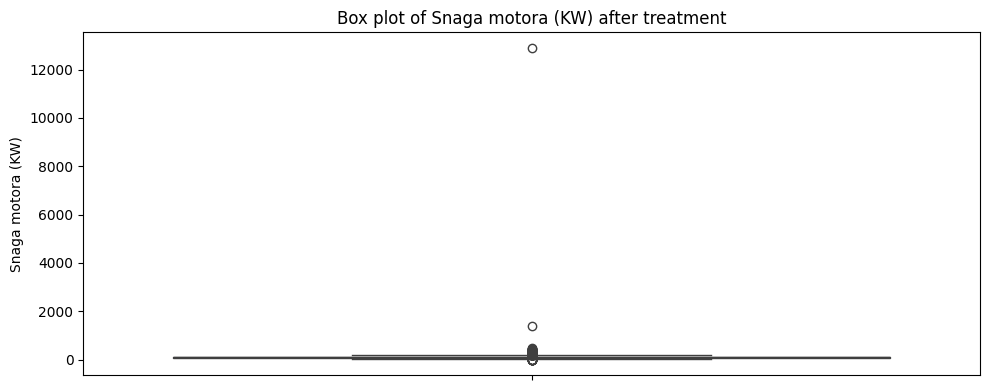

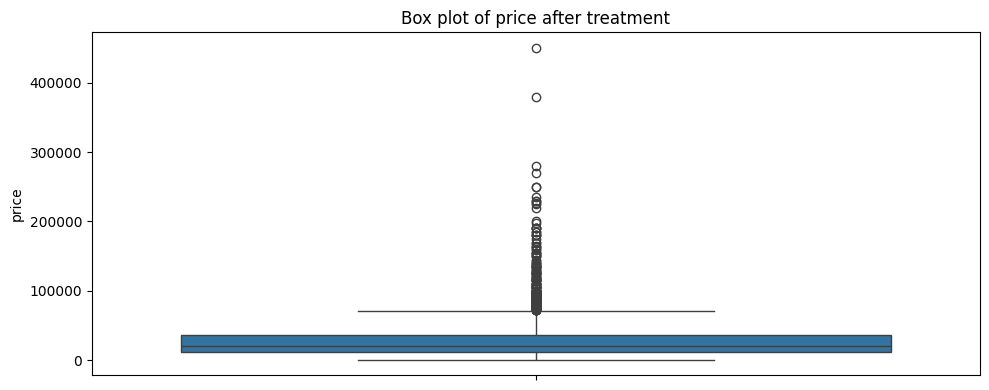

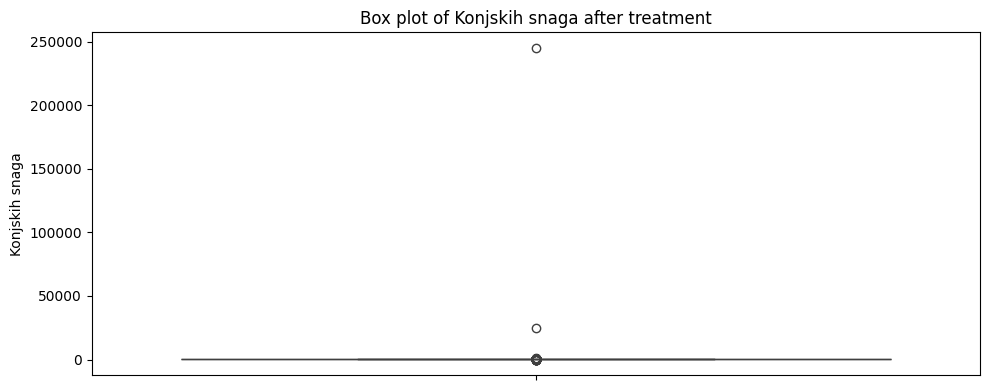

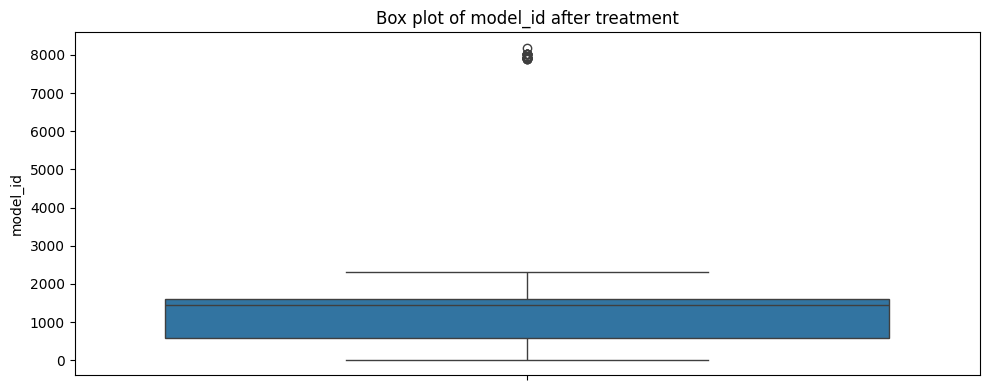

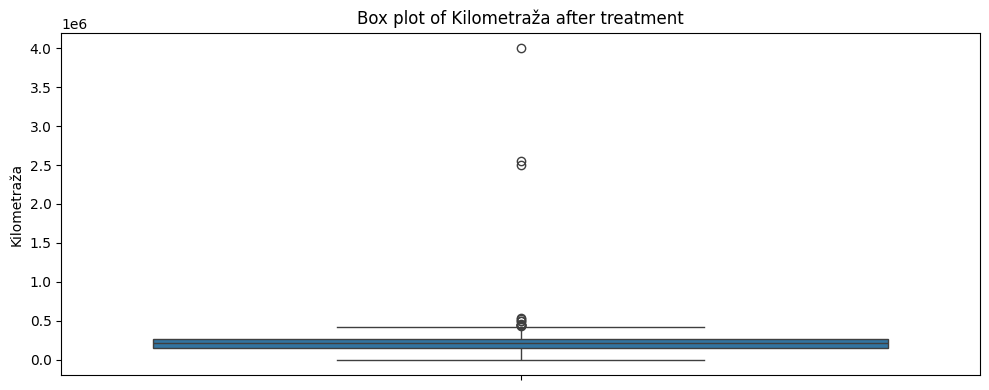

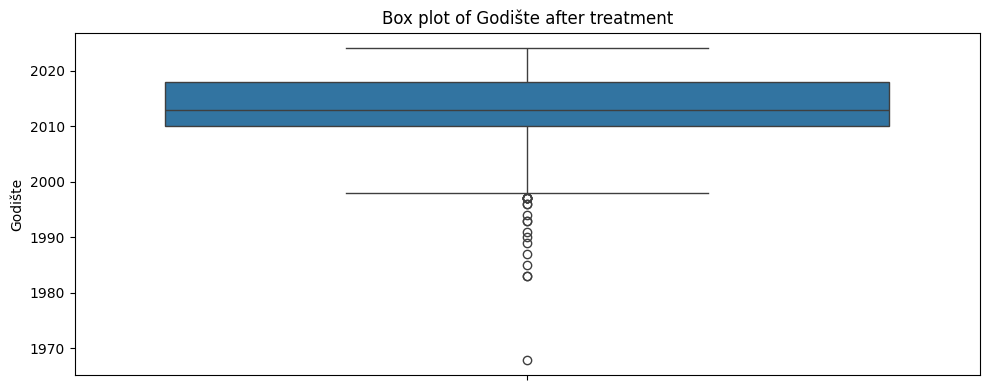

In [7]:
# Vizualizacija box plotova za numeričke kolone nakon tretiranja outlayera
for column in numeric_columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(y=df[column])
    plt.title(f'Box plot of {column} after treatment')
    plt.tight_layout()
    plt.show()


In [8]:
# Prtvaramo preostale kategoricke varijable u numeričke pomoću One-Hot Encoding-a
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Provjera prvih nekoliko redova nakon One-Hot Encoding-a
print(df.head())


   DPF/FAP filter  Kubikaža  Digitalna klima  Alarm  price_by_agreement  \
0            True       3.0             True   True               False   
1            True       1.9             True  False               False   
3            True       2.0             True   True               False   
4            True       1.9            False  False               False   
5            True       1.6             True   True               False   

   views  Memorija sjedišta  Bluetooth  Senzor kiše  Servisna knjiga  ...  \
0   5574              False       True         True             True  ...   
1    850              False      False         True            False  ...   
3   1154              False       True         True             True  ...   
4    201              False       True        False            False  ...   
5  11380              False       True         True             True  ...   

   model_e-Golf  model_i20  model_i3  model_i30  model_ix35  Gorivo_Dizel  \
0        

> # PODACI ZA TRENIRANJE I TESTIRANJE




In [9]:
from sklearn.model_selection import train_test_split

# podjela podataka na ulazne značajke (X) i ciljnu varijablu (y)
X = df.drop('price', axis=1)  # uzimamo da je 'price' ciljana varijabla
y = df['price']

# podjela na trening i testni skup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Trening skup:", X_train.shape, y_train.shape)
print("Testni skup:", X_test.shape, y_test.shape)


Trening skup: (3205, 609) (3205,)
Testni skup: (802, 609) (802,)


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


> # Neuralne mreze

Epoch 1/100
101/101 [==============================] - 1s 6ms/step - loss: 1592735872.0000 - val_loss: 1378925824.0000
Epoch 2/100
101/101 [==============================] - 0s 4ms/step - loss: 1042271680.0000 - val_loss: 640240896.0000
Epoch 3/100
101/101 [==============================] - 1s 6ms/step - loss: 525522528.0000 - val_loss: 658304320.0000
Epoch 4/100
101/101 [==============================] - 1s 6ms/step - loss: 452429312.0000 - val_loss: 624275648.0000
Epoch 5/100
101/101 [==============================] - 1s 6ms/step - loss: 395994272.0000 - val_loss: 602579392.0000
Epoch 6/100
101/101 [==============================] - 1s 6ms/step - loss: 342352672.0000 - val_loss: 583196544.0000
Epoch 7/100
101/101 [==============================] - 1s 6ms/step - loss: 316245024.0000 - val_loss: 573461888.0000
Epoch 8/100
101/101 [==============================] - 1s 7ms/step - loss: 287213312.0000 - val_loss: 547456448.0000
Epoch 9/100
101/101 [==============================] - 1s 5ms

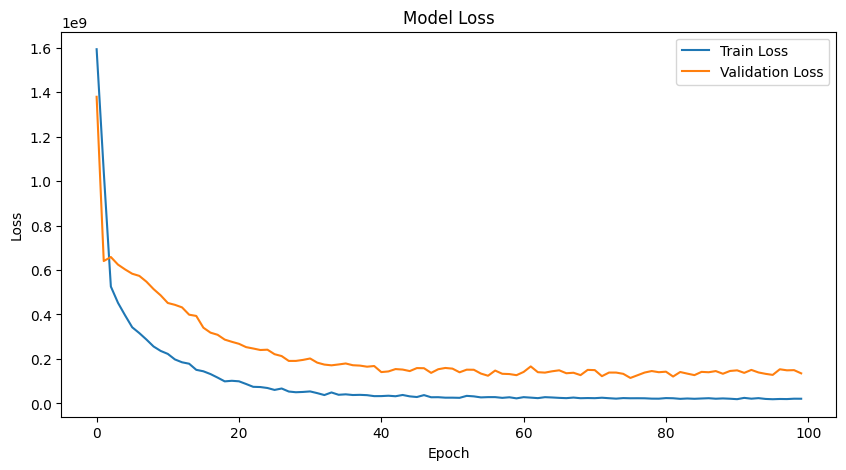

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definisanje neuronske mreže
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
# Kompajliranje modela
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Treniranje modela
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

# Evaluacija modela
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Neural Network Mean Squared Error: {mse}")
print(f"Neural Network R^2 Score: {r2}")

# Plot loss kroz epohe
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

> # Gradient Boosting

In [14]:
from sklearn.preprocessing import StandardScaler

# normalizacija numeričkih varijabli
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
from sklearn.ensemble import GradientBoostingRegressor

# kreiranje instance Gradient Boosting regressor modela
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)

# treniranje modela
gbr.fit(X_train, y_train)

# predviđanje na testnom skupu
y_pred_gbr = gbr.predict(X_test)

# evaluacija modela
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting Regressor R^2 Score: {r2_gbr}")


Gradient Boosting Regressor Mean Squared Error: 59315016.38124289
Gradient Boosting Regressor R^2 Score: 0.9184244738329189


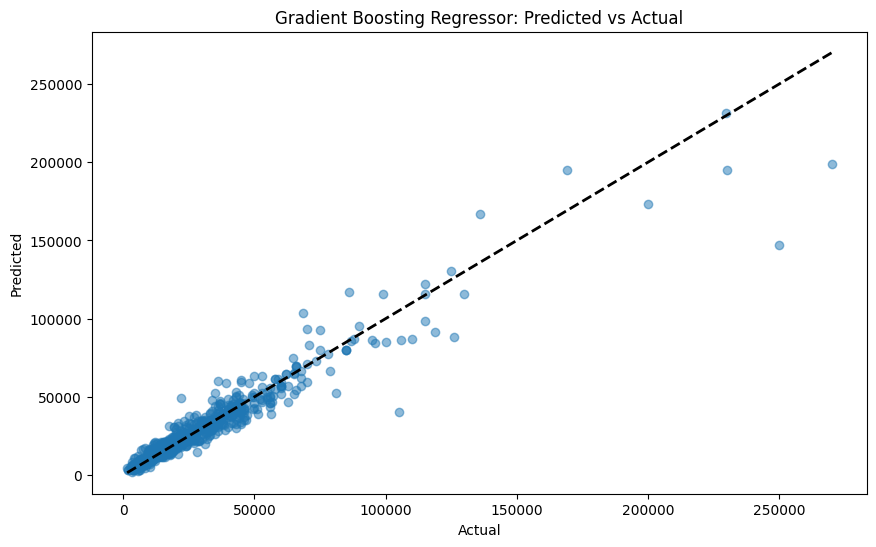

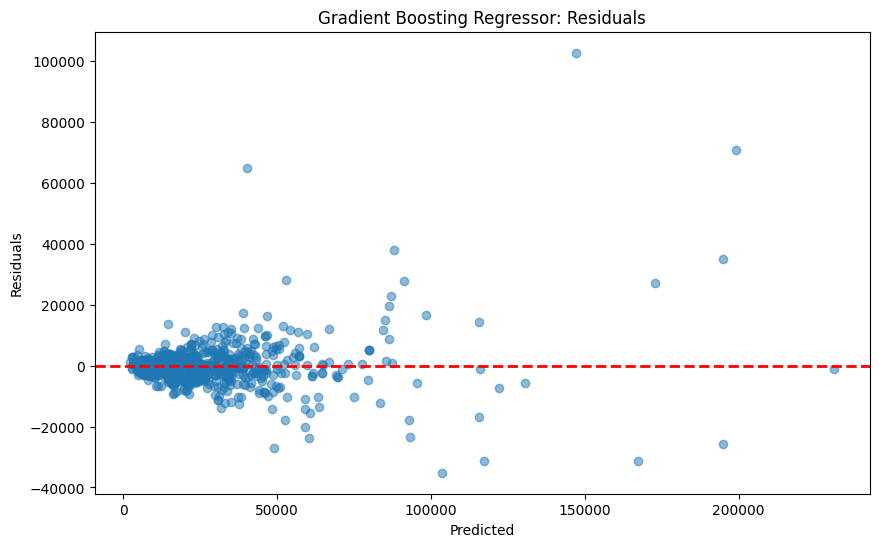

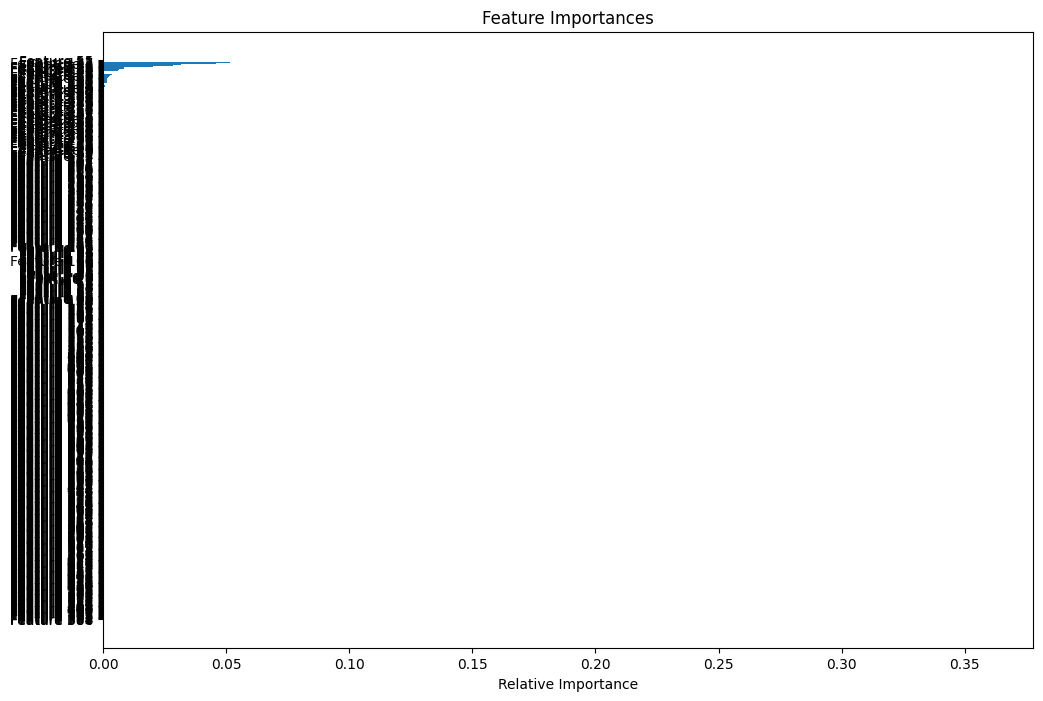

In [21]:
import matplotlib.pyplot as plt

# predviđene naspram stvarne vrijednosti
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gbr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting Regressor: Predicted vs Actual')
plt.show()

# razlike između stvarnih i predviđenih vrijednosti
residuals = y_test - y_pred_gbr
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gbr, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Gradient Boosting Regressor: Residuals')
plt.show()

# važnosti značajki
importances = gbr.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices] if hasattr(X_train, 'columns') else [f'Feature {i}' for i in indices])
plt.xlabel('Relative Importance')
plt.show()
